<a href="https://colab.research.google.com/github/matsunagalab/lecture_ML/blob/main/machine_learning_13_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第13回 ニューラルネットワークその3: 代表的なニューラルネット VAE

## Variational Autoencoder(VAE)をMNIST (digits datase)へ応用

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.datasets import load_digits
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and normalize the digits dataset
digits = load_digits()
data = digits.data / 16.  # normalize the data to 0-1
data = data.astype(np.float32)

data_labels = digits.target

# Define the Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=32, z_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, z_dim * 2)  # mean and variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# Initialize the model, optimizer and loss function
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss(reduction='sum')

# Convert the data to a PyTorch tensor
data = torch.from_numpy(data).to(device)

# Training loop
for epoch in range(10000):
    model.train()
    optimizer.zero_grad()
    recon, mu, logvar = model(data)
    loss = criterion(recon, data)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss += kl_divergence
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 81043.4765625
Epoch: 1000, Loss: 45003.38671875
Epoch: 2000, Loss: 44110.46875
Epoch: 3000, Loss: 43651.03125
Epoch: 4000, Loss: 43477.0390625
Epoch: 5000, Loss: 43345.46875
Epoch: 6000, Loss: 43112.28125
Epoch: 7000, Loss: 43049.4921875
Epoch: 8000, Loss: 43007.71875
Epoch: 9000, Loss: 42945.22265625


## 2次元の潜在変数を可視化

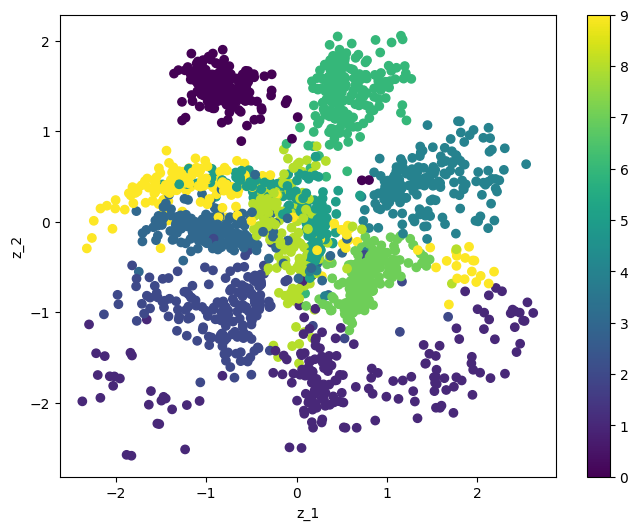

In [2]:
# Visualize the 2-D latent space
model.eval()
with torch.no_grad():
    _, mu, _ = model(data)
mu = mu.cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(mu[:, 0], mu[:, 1], c=data_labels, cmap='viridis')
plt.colorbar()
plt.xlabel('z_1')
plt.ylabel('z_2')
plt.show()

## 潜在変数の0から1まで連続的に移動して画像を生成

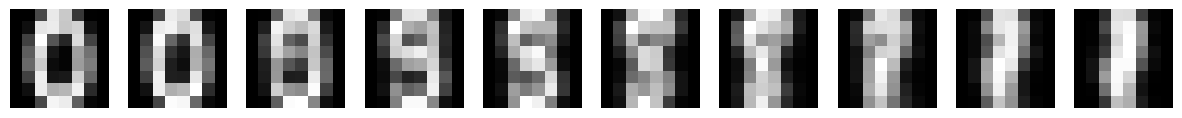

In [3]:
# "Walk through" from "zero" to "nine"
z_zero = mu[data_labels == 0].mean(axis=0)
z_nine = mu[data_labels == 1].mean(axis=0)

z = np.linspace(z_zero, z_nine, 10)
z = torch.from_numpy(z).float().to(device)

with torch.no_grad():
    samples = model.decoder(z)

# Visualize the generated samples
samples = samples.view(-1, 8, 8)  # assuming the input images are 8x8
samples = samples.cpu().numpy()

fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i, ax in enumerate(axs):
    ax.imshow(samples[i], cmap='gray')
    ax.axis('off')
plt.show()